# CatBoost basics

For this homework will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

As a result of this tutorial you need to provide a tsv file with answers.
There are 17 questions in this tutorial. The resulting tsv file should consist of 17 lines, each line should contain the number of the question, an answer to it and a tab separater between them. Questions are numbered from 1 to 17.
See an example of the resulting file here.

## Reading the data

Let's first download the data and put it to folder `amazon`. Now we will read this data from file.

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import datasets
from catboost import *

from grader_v2 import Grader

In [2]:
train_df, test_df = catboost.datasets.amazon()
train_df.head()

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

In [3]:
grader = Grader()

## Preparing your data

Label values extraction

In [4]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [5]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
X.head()

RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  ROLE_TITLE  \
0     39353   85475         117961         118300         123472      117905   
1     17183    1540         117961         118343         123125      118536   
2     36724   14457         118219         118220         117884      117879   
3     36135    5396         117961         118343         119993      118321   
4     42680    5905         117929         117930         119569      119323   

   ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0            117906       290919     117908  
1            118536       308574     118539  
2            267952        19721     117880  
3            240983       290919     118322  
4            123932        19793     119325

Now it makes sense to ananyze the dataset.
First you need to calculate how many positive and negative objects are present in the train dataset.

**Question 1:**

How many negative objects are present in the train dataset X?

In [117]:
y.unique()

array([1, 0])

In [118]:
(y == 0).sum()

1897

In [24]:
zero_count = 1897
grader.submit_tag('negative_samples', zero_count)

Current answer for task negative_samples is: 1897


**Question 2:**

How many positive objects are present in the train dataset X?

In [120]:
(y==1).sum()

30872

In [23]:
one_count = 30872
grader.submit_tag('positive_samples', one_count)

Current answer for task positive_samples is: 30872


In [122]:
print('Zero count = ' + str(zero_count) + ', One count = ' + str(one_count))

Zero count = 1897, One count = 30872


Now for every feature you need to calculate number of unique values of this feature.

**Question 3:**
    
How many unique values has feature RESOURCE?

In [126]:
len(X.RESOURCE.unique())

7518

In [22]:
unique_vals_for_RESOURCE = 7518
grader.submit_tag('resource_unique_values', unique_vals_for_RESOURCE)

Current answer for task resource_unique_values is: 7518


Now we can create a Pool object. This type is used for datasets in CatBoost. You can also use numpy array or dataframe. Working with Pool class is the most efficient way in terms of memory and speed. We recommend to create Pool from file in case if you have your data on disk or from FeaturesData if you use numpy.

In [30]:
import numpy as np
from catboost import Pool

pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(data='/opt/conda/lib/python3.6/site-packages/catboost/cached_datasets/amazon/train.csv', delimiter=',', has_header=True)
pool3 = Pool(data=X, cat_features=cat_features)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) + '\ndataset 2:' + str(pool2.shape)  + '\ndataset 3:' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1: ')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)


Column names
dataset 1: 
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## Split your data into train and validation

When you will be training your model, you will have to detect overfitting and select best parameters. To do that you need to have a validation dataset.
Normally you would be using some random split, for example
`train_test_split` from `sklearn.model_selection`.
But for the purpose of this homework the train part will be the first 80% of the data and the evaluation part will be the last 20% of the data.

In [29]:
train_count = int(X.shape[0] * 0.8)

X_train = X.iloc[:train_count,:]
y_train = y[:train_count]
X_validation = X.iloc[train_count:, :]
y_validation = y[train_count:]

## Train your model

Now we will train our first model.

In [23]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    random_seed=0,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent'
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())
print()

Model is fitted: True
Model params:
{'random_seed': 0, 'loss_function': 'Logloss', 'learning_rate': 0.1, 'iterations': 5}

CPU times: user 781 ms, sys: 159 ms, total: 940 ms
Wall time: 1.93 s


## Stdout of the training

You can see in stdout values of the loss function on each iteration, or on each k-th iteration.
You can also see how much time passed since the start of the training and how much time is left.

In [24]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
    verbose=3
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 49.8ms	remaining: 697ms
3:	learn: 0.1800237	test: 0.1674121	best: 0.1674121 (3)	total: 1.55s	remaining: 4.27s
6:	learn: 0.1706950	test: 0.1549520	best: 0.1549520 (6)	total: 2.85s	remaining: 3.25s
9:	learn: 0.1672391	test: 0.1495040	best: 0.1495040 (9)	total: 3.95s	remaining: 1.97s
12:	learn: 0.1645499	test: 0.1487789	best: 0.1487789 (12)	total: 5.34s	remaining: 822ms
14:	learn: 0.1630092	test: 0.1469375	best: 0.1469375 (14)	total: 6.34s	remaining: 0us

bestTest = 0.1469374586
bestIteration = 14



## Random seed

If you don't specify random_seed then random seed will be set to a new value each time.
After the training has finished you can look on the value of the random seed that was set.
If you train again with this random_seed, you will get the same results.

In [25]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 45.1ms	remaining: 180ms
1:	learn: 0.2161146	test: 0.2152075	best: 0.2152075 (1)	total: 642ms	remaining: 962ms
2:	learn: 0.1879597	test: 0.1797290	best: 0.1797290 (2)	total: 1.04s	remaining: 693ms
3:	learn: 0.1800237	test: 0.1674121	best: 0.1674121 (3)	total: 1.55s	remaining: 387ms
4:	learn: 0.1732668	test: 0.1581682	best: 0.1581682 (4)	total: 2.14s	remaining: 0us

bestTest = 0.1581682309
bestIteration = 4



In [26]:
random_seed = model.random_seed_
print('Used random seed = ' + str(random_seed))
model = CatBoostClassifier(
    iterations=5,
    random_seed=random_seed
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Used random seed = 0
0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 44.7ms	remaining: 179ms
1:	learn: 0.2161146	test: 0.2152075	best: 0.2152075 (1)	total: 642ms	remaining: 963ms
2:	learn: 0.1879597	test: 0.1797290	best: 0.1797290 (2)	total: 1.04s	remaining: 695ms
3:	learn: 0.1800237	test: 0.1674121	best: 0.1674121 (3)	total: 1.55s	remaining: 387ms
4:	learn: 0.1732668	test: 0.1581682	best: 0.1581682 (4)	total: 2.05s	remaining: 0us

bestTest = 0.1581682309
bestIteration = 4



Try training 10 models with parameters and calculate mean and the standart deviation of Logloss error on validation dataset.

**Question 4:**

What is the mean value of the Logloss metric on validation dataset (X_validation, y_validation) after 10 times training `CatBoostClassifier` with different random seeds in the following way:

`model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    random_seed={my_random_seed}
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)
`

In [64]:
%%time
from tqdm import tqdm_notebook

seeds = np.arange(0, 10, 1)
scores = []
for my_random_seed in tqdm_notebook(seeds):
    print('seed={}'.format(my_random_seed))
    print()
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        random_seed=my_random_seed,
        verbose=100,
    )
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_validation, y_validation),
    )
    
    scores.append(model.get_best_score()['validation_0']['Logloss'])
    

print()
print('Average log loss: {}'.format(np.mean(scores)))
print()

A Jupyter Widget

seed=0

0:	learn: 0.5790122	test: 0.5797377	best: 0.5797377 (0)	total: 113ms	remaining: 33.8s
100:	learn: 0.1555506	test: 0.1394226	best: 0.1394226 (100)	total: 41.5s	remaining: 1m 21s
200:	learn: 0.1486424	test: 0.1381162	best: 0.1381162 (200)	total: 1m 28s	remaining: 43.6s
299:	learn: 0.1452004	test: 0.1379528	best: 0.1377092 (262)	total: 2m 16s	remaining: 0us

bestTest = 0.1377092211
bestIteration = 262

Shrink model to first 263 iterations.
seed=1

0:	learn: 0.5785828	test: 0.5796621	best: 0.5796621 (0)	total: 139ms	remaining: 41.5s
100:	learn: 0.1542598	test: 0.1402208	best: 0.1401744 (97)	total: 42.5s	remaining: 1m 23s
200:	learn: 0.1476642	test: 0.1391333	best: 0.1390896 (197)	total: 1m 29s	remaining: 43.9s
299:	learn: 0.1441857	test: 0.1394407	best: 0.1390896 (197)	total: 2m 18s	remaining: 0us

bestTest = 0.1390896115
bestIteration = 197

Shrink model to first 198 iterations.
seed=2

0:	learn: 0.5763417	test: 0.5764993	best: 0.5764993 (0)	total: 428ms	remaining: 2m 8s
100:	lear

In [72]:
print(np.mean(scores))
print(np.std(scores))

0.138180847126
0.000777781825619


In [94]:
print(np.mean(scores[4:]))
print(np.std(scores[4:]))

0.138152768119
0.000762290845861


### Selected Mean

In [7]:
# Seed 0: 0.1377092
# Seed 1: 0.1390896
# Seed 3: 0.1371881
# Seed 6: 0.1371346

scores_selected = [0.1377092, 0.1390896, 0.1371881, 0.1371346]
print(np.mean(scores_selected))
print(np.std(scores_selected))

0.137780375
0.000788503488816


In [21]:
mean = 0.137780375
grader.submit_tag('logloss_mean', mean)

Current answer for task logloss_mean is: 0.137780375


**Question 5:**

What is the standard deviation of it?

In [68]:
print(np.std(scores))

0.000777781825619


In [20]:
stddev = 0.000788503488816
grader.submit_tag('logloss_std', stddev)

Current answer for task logloss_std is: 0.000788503488816


## Metrics calculation and graph plotting

When experimenting with Jupyter notebook you can see graphs of different errors during training.
To do that you need to use `plot=True` parameter.

In [52]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

A Jupyter Widget

**Question 6:**

What is the value of the accuracy metric value on evaluation dataset after training with parameters `iterations=50`, `random_seed=63`, `learning_rate=0.1`?

In [19]:
accuracy = 0.9539
grader.submit_tag('accuracy_6', accuracy)

Current answer for task accuracy_6 is: 0.9539


## Model comparison

In [54]:
model1 = CatBoostClassifier(
    learning_rate=0.5,
    iterations=1000,
    random_seed=64,
    train_dir='learning_rate_0.5',
    custom_loss = ['Accuracy']
)

model2 = CatBoostClassifier(
    learning_rate=0.05,
    iterations=1000,
    random_seed=64,
    train_dir='learning_rate_0.05',
    custom_loss = ['Accuracy']
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=100
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=100
)

0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 72.6ms	remaining: 1m 12s
100:	learn: 0.1416460	test: 0.1404156	best: 0.1402309 (96)	total: 55.2s	remaining: 8m 11s
200:	learn: 0.1340506	test: 0.1447274	best: 0.1399893 (106)	total: 1m 50s	remaining: 7m 17s
300:	learn: 0.1281182	test: 0.1478018	best: 0.1399893 (106)	total: 2m 45s	remaining: 6m 23s
400:	learn: 0.1213678	test: 0.1506548	best: 0.1399893 (106)	total: 3m 41s	remaining: 5m 30s
500:	learn: 0.1178627	test: 0.1527704	best: 0.1399893 (106)	total: 4m 37s	remaining: 4m 36s
600:	learn: 0.1145490	test: 0.1531613	best: 0.1399893 (106)	total: 5m 33s	remaining: 3m 41s
700:	learn: 0.1121429	test: 0.1548145	best: 0.1399893 (106)	total: 6m 28s	remaining: 2m 45s
800:	learn: 0.1087987	test: 0.1576137	best: 0.1399893 (106)	total: 7m 25s	remaining: 1m 50s
900:	learn: 0.1064078	test: 0.1590852	best: 0.1399893 (106)	total: 8m 20s	remaining: 55s
999:	learn: 0.1037092	test: 0.1610907	best: 0.1399893 (106)	total: 9m 17s	remaining: 0us


In [55]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.05', 'learning_rate_0.5']).start()

A Jupyter Widget

**Question 7:**

Try training these models for 1000 iterations. Which model will give better best resulting Accuracy on validation dataset?
By best resulting accuracy we mean accuracy on best iteration, which might be not the last iteration.

In [18]:
best_model_name = 'learning_rate_0.05' # one of 'learning_rate_0.5', 'learning_rate_0.05'
grader.submit_tag('best_model_name', best_model_name)

Current answer for task best_model_name is: learning_rate_0.05


## Best iteration

If a validation dataset is present then after training, the model is shrinked to a number of trees when it got best evaluation metric value on validation dataset.
By default evaluation metric is the optimized metric. But you can set evaluation metric to some other metric.
In the example below evaluation metric is `Accuracy`.

In [59]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

A Jupyter Widget

In [60]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 72


If you don't want the model to be shrinked, you can set `use_best_model=False`

In [61]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy',
    use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

A Jupyter Widget

In [62]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 100


**Question 8:**
    
What will be the number of trees in the resulting model after training with validation dataset with parameters `iterations=100`, ` learning_rate=0.5`, `eval_metric='Accuracy'` and with parameter `use_best_model=False`

In [17]:
tree_count = 100
grader.submit_tag('num_trees', tree_count)

Current answer for task num_trees is: 100


## Cross-validation

The next functionality you need to know about is cross-validation.
For unbalanced datasets stratified cross-validation can be useful.

In [64]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    inverted=False,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

A Jupyter Widget

Cross-validation returns specified metric values on every iteration (or every k-th iteration, if you specify so)

In [65]:
print(cv_data[0:4])

   test-AUC-mean  test-AUC-std  test-Logloss-mean  test-Logloss-std  \
0       0.500000      0.000000           0.302197          0.000080   
1       0.625621      0.122336           0.222651          0.014472   
2       0.799508      0.012871           0.179930          0.004739   
3       0.824558      0.013151           0.165090          0.003799   

   train-AUC-mean  train-AUC-std  train-Logloss-mean  train-Logloss-std  
0        0.499984       0.000017            0.302203           0.000050  
1        0.614679       0.109875            0.225825           0.010991  
2        0.758325       0.022924            0.190024           0.004146  
3        0.781285       0.017559            0.178807           0.003176  


Let's look on mean value and standard deviation of Logloss for cv on best iteration.

In [103]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1409±0.0056 on step 65


In [107]:
best_iter

65

**Question 9:**

Try running stratified cross-validation with the same parameters. What will be mean of Logloss metric on test of the stratified cross-validation on the best iteration?

In [108]:
cv_data['test-Logloss-mean'][65]

0.14086208089916841

In [16]:
mean_on_best_iteration = 0.14086208089916841
grader.submit_tag('mean_logloss_cv', mean_on_best_iteration)

Current answer for task mean_logloss_cv is: 0.1408620808991684


**Question 10:**

Try running stratified cross-validation with the same parameters. What will be the standard deviation of Logloss metric of the stratified cross-validation on the best iteration?

In [109]:
cv_data['test-Logloss-std'][65]

0.0055622410138013046

In [15]:
std_on_best_iteration = 0.0055622410138013046
grader.submit_tag('logloss_std_1', std_on_best_iteration)

Current answer for task logloss_std_1 is: 0.005562241013801305


## Overfitting detector

A useful feature of the library is overfitting detector.
Let's try training the model with early stopping.

In [69]:
%%time
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    od_type='Iter',
    od_wait=20,
    eval_metric = 'AUC'
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

A Jupyter Widget

CPU times: user 18.4 s, sys: 4.8 s, total: 23.2 s
Wall time: 46.9 s


In [85]:
print('Best step: {}'.format(model_with_early_stop.best_iteration_))
print('Number of training log: {}'.format(len(model_with_early_stop.get_evals_result()['validation_0']['Logloss'])))

Best step: 64
Number of training log: 85


**Question 11:**

Now try training the model with the same parameters and with overfitting detector, but with `eval_metric='AUC'`
What will be the number of iterations after which the training will stop?
(Not the number of trees in the resulting model, but the number of iterations that the algorithm will perform befor training).

In [14]:
iterations_count = 85
grader.submit_tag('iterations_overfitting', iterations_count)

Current answer for task iterations_overfitting is: 85


## Snapshotting

If you train for long time, for example for several hours, you need to save snapshots.
Otherwise if your laptop or your server will reboot, you will loose all the progress.
To do that you need to specify `snapshot_file` parameter.
Try running the code below and interrupting the kernel after short time.
Then try running the same cell again.
The training will start from the iteration when the training was interrupted.
Note that all additional files are written by default into `catboost_info` directory. It can be changed using `train_dir` parameter. So the snapshot file will be there.

In [87]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=40,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)

0:	learn: 0.3284341	test: 0.3318014	best: 0.3318014 (0)	total: 400ms	remaining: 15.6s
1:	learn: 0.2435617	test: 0.2470202	best: 0.2470202 (1)	total: 799ms	remaining: 15.2s
2:	learn: 0.1973609	test: 0.1922760	best: 0.1922760 (2)	total: 1.3s	remaining: 16.1s
3:	learn: 0.1838698	test: 0.1745423	best: 0.1745423 (3)	total: 1.9s	remaining: 17.1s
4:	learn: 0.1769813	test: 0.1634033	best: 0.1634033 (4)	total: 2.3s	remaining: 16.1s
5:	learn: 0.1729134	test: 0.1575425	best: 0.1575425 (5)	total: 2.9s	remaining: 16.4s
6:	learn: 0.1719994	test: 0.1558761	best: 0.1558761 (6)	total: 3.3s	remaining: 15.6s
7:	learn: 0.1703007	test: 0.1537828	best: 0.1537828 (7)	total: 3.7s	remaining: 14.8s
8:	learn: 0.1682803	test: 0.1513517	best: 0.1513517 (8)	total: 4.2s	remaining: 14.5s
9:	learn: 0.1666971	test: 0.1503261	best: 0.1503261 (9)	total: 4.7s	remaining: 14.1s
10:	learn: 0.1660670	test: 0.1500227	best: 0.1500227 (10)	total: 5.1s	remaining: 13.4s
11:	learn: 0.1654023	test: 0.1500106	best: 0.1500106 (11)	tot

## Model predictions

There are multiple ways to do predictions.
The easiest one is to call predict or predict_proba.
You also can make predictions using C++ code. For that see [documentation](https://tech.yandex.com/catboost/doc/dg/concepts/c-plus-plus-api-docpage/).

In [88]:
print(model.predict_proba(data=X_validation))

[[ 0.0159  0.9841]
 [ 0.0157  0.9843]
 [ 0.0059  0.9941]
 ..., 
 [ 0.0071  0.9929]
 [ 0.3818  0.6182]
 [ 0.0263  0.9737]]


In [89]:
print(model.predict(data=X_validation))

[ 1.  1.  1. ...,  1.  1.  1.]


For binary classification resulting value is not necessary a value in `[0,1]`. It is some numeric value. To get the probability out of this value you need to calculate sigmoid of that value.

In [90]:
raw_pred = model.predict(data=X_validation, prediction_type='RawFormulaVal')
print(raw_pred)

[ 4.1255  4.1387  5.122  ...,  4.9439  0.4819  3.6114]


In [91]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
probabilities = [sigmoid(x) for x in raw_pred]
print(np.array(probabilities))

[ 0.9841  0.9843  0.9941 ...,  0.9929  0.6182  0.9737]


## Staged prediction

CatBoost also supports staged prediction - when you want to have a prediction on each object on each iteration (or on each k-th iteration). This can be used if you want to calculate the values of some custom metric using the predictions.

In [92]:
predictions_gen = model.staged_predict_proba(data=X_validation, ntree_start=0, ntree_end=5, eval_period=1)
for iteration, predictions in enumerate(predictions_gen):
    print('Iteration ' + str(iteration) + ', predictions:')
    print(predictions)

Iteration 0, predictions:
[[ 0.228  0.772]
 [ 0.228  0.772]
 [ 0.228  0.772]
 ..., 
 [ 0.228  0.772]
 [ 0.228  0.772]
 [ 0.228  0.772]]
Iteration 1, predictions:
[[ 0.1121  0.8879]
 [ 0.1273  0.8727]
 [ 0.1121  0.8879]
 ..., 
 [ 0.1121  0.8879]
 [ 0.221   0.779 ]
 [ 0.1526  0.8474]]
Iteration 2, predictions:
[[ 0.0599  0.9401]
 [ 0.0686  0.9314]
 [ 0.0599  0.9401]
 ..., 
 [ 0.0599  0.9401]
 [ 0.3378  0.6622]
 [ 0.0833  0.9167]]
Iteration 3, predictions:
[[ 0.0424  0.9576]
 [ 0.0486  0.9514]
 [ 0.0424  0.9576]
 ..., 
 [ 0.0424  0.9576]
 [ 0.3799  0.6201]
 [ 0.0594  0.9406]]
Iteration 4, predictions:
[[ 0.0267  0.9733]
 [ 0.0435  0.9565]
 [ 0.0267  0.9733]
 ..., 
 [ 0.0379  0.9621]
 [ 0.3549  0.6451]
 [ 0.0531  0.9469]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'CatBoost._staged_predict' raised StopIteration
  


## Metric evaluation on a new dataset

You can also calculate metrics directly after training.

In [93]:
metrics = model.eval_metrics(data=pool1, metrics=['Logloss','AUC'], plot=True)

In [94]:
print('AUC values:')
print(np.array(metrics['AUC']))

AUC values:

A Jupyter Widget


[ 0.4999  0.6183  0.878   0.9372  0.9332  0.9456  0.9505  0.9542  0.9548
  0.9562  0.9561  0.9578  0.9665  0.9667  0.9668  0.9668  0.9703  0.9706
  0.9719  0.9716  0.9726  0.9729  0.9728  0.9729  0.973   0.973   0.973
  0.9744  0.9743  0.9753  0.9782  0.9782  0.9782  0.9782  0.9782  0.9782
  0.9781  0.9781  0.9779  0.9818]


**Question 12:**

Now train a model in the following way:

`
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)
`

What will be the AUC value on 550 iteration if evaluation metrics on the initial X dataset?

In [96]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=43,
    verbose=50
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)

0:	learn: 0.6335962	test: 0.6340206	best: 0.6340206 (0)	total: 210ms	remaining: 3m 29s
50:	learn: 0.1736628	test: 0.1609880	best: 0.1609880 (50)	total: 22.4s	remaining: 6m 56s
100:	learn: 0.1609553	test: 0.1447964	best: 0.1447964 (100)	total: 47.2s	remaining: 7m
150:	learn: 0.1580958	test: 0.1422491	best: 0.1422491 (150)	total: 1m 9s	remaining: 6m 30s
200:	learn: 0.1558555	test: 0.1411513	best: 0.1411513 (200)	total: 1m 33s	remaining: 6m 10s
250:	learn: 0.1528539	test: 0.1396550	best: 0.1396550 (250)	total: 2m	remaining: 6m
300:	learn: 0.1509529	test: 0.1391401	best: 0.1391292 (297)	total: 2m 28s	remaining: 5m 45s
350:	learn: 0.1495882	test: 0.1389594	best: 0.1389428 (349)	total: 2m 57s	remaining: 5m 28s
400:	learn: 0.1482021	test: 0.1391781	best: 0.1389002 (376)	total: 3m 25s	remaining: 5m 7s
450:	learn: 0.1470913	test: 0.1390602	best: 0.1389002 (376)	total: 3m 55s	remaining: 4m 46s
500:	learn: 0.1461119	test: 0.1389435	best: 0.1389002 (376)	total: 4m 25s	remaining: 4m 24s
550:	learn:

In [97]:
metrics = model.eval_metrics(data=pool1, metrics=['AUC', 'Logloss'], plot=True)

In [98]:
print('AUC values:')
print(np.array(metrics['AUC'])[550])

AUC values:
0.984975697775


A Jupyter Widget

In [13]:
auc_value = 0.984975697775
grader.submit_tag('auc_550', auc_value)

Current answer for task auc_550 is: 0.984975697775


## Feature importances

Now we will learn how to understand which features are the most important ones. Let's first train the model that will not use feature combinations. To forbid feature combinations you need to use 'max_ctr_complexity=1'. This will speed up the training by a lot, but it will reduce the resulting quality. 

In [12]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=4,
#     max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.5454508	total: 508ms	remaining: 2m 31s
50:	learn: 0.1562605	total: 20.7s	remaining: 1m 41s
100:	learn: 0.1493646	total: 43.3s	remaining: 1m 25s
150:	learn: 0.1451569	total: 1m 8s	remaining: 1m 7s
200:	learn: 0.1432905	total: 1m 33s	remaining: 46.1s
250:	learn: 0.1417401	total: 1m 57s	remaining: 23s
299:	learn: 0.1402619	total: 2m 22s	remaining: 0us
CPU times: user 56.4 s, sys: 14 s, total: 1min 10s
Wall time: 2min 23s


Let's see which features are most important for the model without feature combinations.

In [133]:
# importance when max_ctr_complexity=1
importances = model.get_feature_importance(prettified=True)
print(importances)

[('MGR_ID', 32.298927496642214), ('RESOURCE', 18.516094148023672), ('ROLE_FAMILY_DESC', 12.987791972755684), ('ROLE_ROLLUP_2', 9.009528339227415), ('ROLE_DEPTNAME', 8.502603783338843), ('ROLE_CODE', 6.465296066682523), ('ROLE_FAMILY', 5.144914966956651), ('ROLE_TITLE', 5.076292845877568), ('ROLE_ROLLUP_1', 1.9985503804954317)]


In [13]:
# importance when max_ctr_complexity=4

importances = model.get_feature_importance(prettified=True)
print(importances)

[('RESOURCE', 24.73509920590257), ('MGR_ID', 17.449161787258667), ('ROLE_DEPTNAME', 15.316223709876839), ('ROLE_ROLLUP_2', 11.490154799409593), ('ROLE_TITLE', 10.71183545081703), ('ROLE_FAMILY_DESC', 8.946143168072846), ('ROLE_FAMILY', 4.379723768290924), ('ROLE_CODE', 3.772023536810539), ('ROLE_ROLLUP_1', 3.199634573560977)]


** Question 13: **

Try training the model without the restriction of combinations, with other parameters set to the same values.
What will be top 3 most important features for this model?

In [ ]:
# For max_ctr_complexity=1, top3 is ['MGR_ID', 'RESOURCE', 'ROLE_FAMILY_DESC']
# For max_ctr_complexity=1, top3 is ['RESOURCE', 'MGR_ID', 'ROLE_DEPTNAME']

In [12]:
top3 = 'MGR_ID,RESOURCE,ROLE_FAMILY_DESC' # You should provide comma separated list of strings. Each string should be in single quotes. All list should be in square brackets.
grader.submit_tag('feature_importance_top3', top3)

Current answer for task feature_importance_top3 is: MGR_ID,RESOURCE,ROLE_FAMILY_DESC


## Shap values

Let's train the model one more time.

In [49]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.5443376	total: 314ms	remaining: 1m 33s
50:	learn: 0.1711369	total: 16.2s	remaining: 1m 19s
100:	learn: 0.1671705	total: 33.8s	remaining: 1m 6s
150:	learn: 0.1649220	total: 54.2s	remaining: 53.5s
200:	learn: 0.1632912	total: 1m 14s	remaining: 36.8s
250:	learn: 0.1622900	total: 1m 34s	remaining: 18.5s
299:	learn: 0.1613767	total: 1m 55s	remaining: 0us
CPU times: user 39.8 s, sys: 17.9 s, total: 57.7 s
Wall time: 1min 55s


The library provides a way to understand which features are important for a given object.
Let's take a look on the whole dataset X and analyze the influence of different features on the objects from this dataset.
We will now calculate importances for each object. After that we will visualize these importances.

In [50]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
shap_values = model.get_feature_importance(data=pool1, fstr_type='ShapValues', verbose=10000)
print(shap_values.shape)

Processing trees...
128/300 trees processed	passed time: 102ms	remaining time: 137ms sec
300/300 trees processed	passed time: 404ms	remaining time: 0us sec
Processing documents...
128/32769 documents processed	passed time: 91ms	remaining time: 23.2s sec
10112/32769 documents processed	passed time: 993ms	remaining time: 2.22s sec
20096/32769 documents processed	passed time: 1.9s	remaining time: 1.2s sec
30080/32769 documents processed	passed time: 2.79s	remaining time: 250ms sec
(32769, 10)


Let's look on the prediction of the model for 0-th object. The raw prediction is not the probability, to calculate probability from raw prediction you need to calculate sigmoid(raw_prediction).

In [56]:
X.iloc[0:1]

RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  ROLE_TITLE  \
0     39353   85475         117961         118300         123472      117905   

   ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0            117906       290919     117908

In [52]:
test_objects = [X.iloc[0:1]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9899
Formula raw prediction = 4.5822




Sum of all shap values are equal to the resulting raw formula predition.
We can see on the graph that will be output below that there is a base value, which is equal for all the objects.
And almost all the feature have positive influence on this object. The biggest step to the right is because of the feature called 'MGR_ID'.

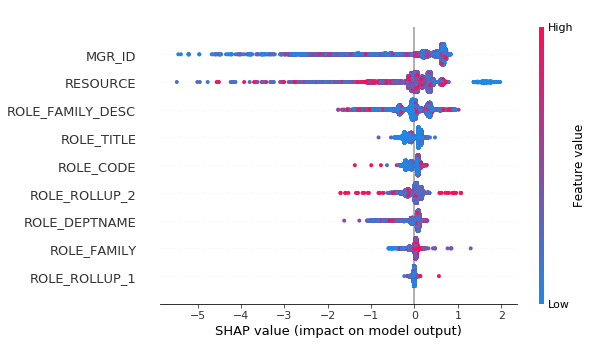

In [58]:
import shap
shap.initjs()
# shap.force_plot(shap_values[0,:], X.iloc[0,:])
shap.summary_plot(shap_values[:,:-1], X)

** Question 14: **

What is the most important feature for 91-th object

In [97]:
index_object = 91
print(shap_values[index_object])
print(shap_values[index_object][:-1].argmax())
print(shap_values[index_object][:-1].argmin())

[-3.3277 -0.4636 -0.014  -0.3015  0.0948 -0.3666 -0.1977  0.0088 -0.2613
  3.4625]
4
0


In [98]:
print(X.columns)
print(X.columns[4])
print(X.columns[0])

Index(['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'],
      dtype='object')
ROLE_DEPTNAME
RESOURCE


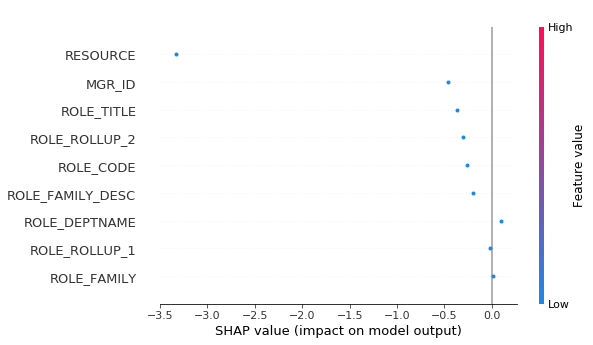

In [90]:
import shap
shap.initjs()
# shap.force_plot(shap_values[0,:], X.iloc[0,:])
shap.summary_plot(shap_values[index_object:index_object+1,:-1], X.iloc[index_object:index_object+1])

In [101]:
most_important_feature = 'RESOURCE'
grader.submit_tag('most_important', most_important_feature)

Current answer for task most_important is: RESOURCE


** Question 15: **

Does it have positive or negative influence? Answer 1 if positive and -1 if negative.

In [104]:
influence_sign = -1
grader.submit_tag('shap_influence', influence_sign)

Current answer for task shap_influence is: -1


You can also view aggregated information about the influences on the whole dataset.

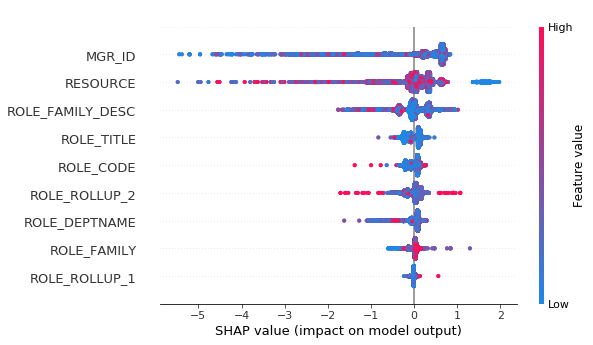

In [106]:
shap.summary_plot(shap_values[:, :-1], X)

From this graph you can see that values of MGR_ID and RESOURCE features have a large negative impact for many objects.
You can also see that RESOURCE has largest positive impact for many objects.

## Saving the model

You can save your model as a binary file. It is also possible to save the model as Python or C++ code.
If you save the model as a binary file you can then look on the parameters with which the model was trained, including learning_rate and random_seed that are set automatically if you don't specify them.

In [31]:
%%time
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')

CPU times: user 1.81 s, sys: 554 ms, total: 2.37 s
Wall time: 5.15 s


In [32]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)
print(my_best_model.learning_rate_)

{'loss_function': 'Logloss', 'iterations': 10, 'logging_level': 'Silent', 'verbose': 0}
0
0.5


## Hyperparameter tunning

You can tune the parameters to get better speed or better quality.
Here is the list of parameters that are important for speed and accuracy.

### Training speed

Here is the list of parameters that are important for speeding up the training.
Note that changing this parameters might decrease the quality.
1. iterations + learning rate
By default we train for 1000 iterations. You can decrease this number, but if you decrease the number of iterations you need to increase learning rate so that the process converges. We set learning rate by default dependent on number of iterations and on your dataset, so you might just use default learning rate. But if you want to tune it, you need to know - the more iterations you have, the less should be the learning rate.

2. boosting_type
By default we use Ordered boosting for smaller datasets where we want to fight overfitting. This is expensive in terms of computations. You can set boosting_type to Plain to disable this.

3. bootstrap_type
By default we sample weights from exponential distribution. It is faster to use sampling from Bernoulli distribution. To enable that use bootstrap_type='Bernoulli' + subsample={some value < 1}

4. one_hot_max_size
By default we use one-hot encoding only for categorical features with little amount of different values. For all other categorical features we calculate statistics. This is expensive, and one-hot encoding is cheep. So you can speed up the training by setting one_hot_max_size to some bigger value

5. rsm
This parameter is very important, because it speeds up the training and does not affect the quality. So you should definitely use it, but only in case if you have hundreds of features.
If you have little amount of features it's better not to use this parameter.
If you have many features then the rule is the following: you decrease rsm, for example, you set rsm=0.1. With this rsm value the training needs more iterations to converge. Usually you need about 20% more iterations. But each iteration will be 10x faster. So the resulting training time will be faster even though you will have more trees in the resulting model.

6. leaf_estimation_iterations
This parameter is responsible for calculating leaf values after you have already selected tree structure.
If you have little amount of features, for example 8 or 10 features, then this place starts to be the bottle-neck.
Default value for this parameter depends on the training objective, you can try setting it to 1 or 5, and if you have little amount of features, this might speed up the training.

7. max_ctr_complexity
By default catboost generates categorical feature combinations in a greedy way.
This is time consuming, you can disable that by setting max_ctr_complexity=1 or by allowing only combinations of 2 features by setting max_ctr_complexity=2.
This will speed up the training only if you have categorical features.

8. If you are training the model on GPU, you can try decreasing border_count. This is the number of splits considered for each feature. By default it's set to 128, but you can try setting it to 32. In many cases it will not degrade the quality of the model and will speed up the training by a lot. 

In [40]:
%%time
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.5,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    border_count=32,
    custom_loss = ['AUC'])

fast_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Silent',
    plot=True
)

A Jupyter Widget

CPU times: user 6.61 s, sys: 2.16 s, total: 8.76 s
Wall time: 17.7 s


In [41]:
print(fast_model.get_best_iteration())

21


### Default Settings

In [38]:
%%time
model_default = CatBoostClassifier(
    iterations=200,
    random_seed=0,
    train_dir='default',
    custom_loss = ['AUC']
)

model_default.fit(X_train, y_train,
                    eval_set=(X_validation, y_validation),
                    cat_features=cat_features,
                    logging_level='Silent',
                    plot=True
                )

A Jupyter Widget

CPU times: user 42.8 s, sys: 12.1 s, total: 54.9 s
Wall time: 1min 51s


In [39]:
print(model_default.get_best_iteration())

56


** Question 16: **

Try tunning the speed of the algorithm. What is the maximum speedup you could get by changing these parameters without decreasing of AUC on best iteration on eval dataset compared to AUC on best iteration after training with default parameters and random seed = 0?
The answer shoud be a number, for example 2.7 means you got 2.7 times speedup.

In [42]:
speedup = 58/21
grader.submit_tag('speedup', speedup)

Current answer for task speedup is: 2.761904761904762


### Accuracy

The parameters listed below are important to get the best quality of the model. Try changing this parameters to improve the quality of the resulting model

In [ ]:
%%time
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6,
    custom_loss = ['AUC']
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    eval_set=(X_validation, y_validation),
    plot=True
)

A Jupyter Widget

CPU times: user 3min 42s, sys: 56.4 s, total: 4min 38s
Wall time: 9min 32s


** Question 17: **

Try tunning these parameters to make AUC on eval dataset as large as possible. What is the maximum AUC value you have reached?

In [46]:
final_auc = 0.9044539794
grader.submit_tag('final_auc', final_auc)

Current answer for task final_auc is: 0.9044539794


In [107]:
STUDENT_EMAIL = 'brandon.hy.lin.0@gmail.com'# EMAIL HERE
STUDENT_TOKEN = 'MVs2K9ITxZl8YI1N'# TOKEN HERE
grader.status()

You want to submit these numbers:
Task negative_samples: 1897
Task positive_samples: 30872
Task resource_unique_values: 7518
Task logloss_mean: 0.137780375
Task logloss_std: 0.000788503488816
Task accuracy_6: 0.9539
Task best_model_name: learning_rate_0.05
Task num_trees: 100
Task mean_logloss_cv: 0.1408620808991684
Task logloss_std_1: 0.005562241013801305
Task iterations_overfitting: 85
Task auc_550: 0.984975697775
Task feature_importance_top3: MGR_ID,RESOURCE,ROLE_FAMILY_DESC
Task most_important: RESOURCE
Task shap_influence: -1
Task speedup: 2.761904761904762
Task final_auc: 0.9044539794


In [108]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
